# Data Preprocessing


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

Mengambil dataset

In [3]:
df = pd.read_csv('Car Sales.xlsx - car_data.csv')
df.head()

,Car_id,Date,Customer Name,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price ($),Dealer_No,Body Style,Phone,Dealer_Region
0,C_CND_000001,1/2/2022,Geraldine,Male,13500,Buddy Storbeck's Diesel Service Inc,Ford,Expedition,DoubleÂ Overhead Camshaft,Auto,Black,26000,06457-3834,SUV,8264678,Middletown
1,C_CND_000002,1/2/2022,Gia,Male,1480000,C & M Motors Inc,Dodge,Durango,DoubleÂ Overhead Camshaft,Auto,Black,19000,60504-7114,SUV,6848189,Aurora
2,C_CND_000003,1/2/2022,Gianna,Male,1035000,Capitol KIA,Cadillac,Eldorado,Overhead Camshaft,Manual,Red,31500,38701-8047,Passenger,7298798,Greenville
3,C_CND_000004,1/2/2022,Giselle,Male,13500,Chrysler of Tri-Cities,Toyota,Celica,Overhead Camshaft,Manual,Pale White,14000,99301-3882,SUV,6257557,Pasco
4,C_CND_000005,1/2/2022,Grace,Male,1465000,Chrysler Plymouth,Acura,TL,DoubleÂ Overhead Camshaft,Auto,Red,24500,53546-9427,Hatchback,7081483,Janesville


Drop kolom-kolom yang tidak akan digunakan

In [4]:
df.drop(columns=['Car_id', 'Dealer_Name', 'Color', 'Dealer_No ', 'Phone', 'Dealer_Region'], inplace=True)

Ubah beberapa nama kolom untuk memudahkan modelling

In [5]:
df.rename(columns={
    'Annual Income': 'annual_income',
    'Price ($)': 'price',
    'Gender': 'gender',
    'Company': 'car_company',
    'Transmission': 'transmission',
    'Engine': 'engine_type',
    'Body Style': 'body_style'
    }, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23906 entries, 0 to 23905
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           23906 non-null  object
 1   Customer Name  23905 non-null  object
 2   gender         23906 non-null  object
 3   annual_income  23906 non-null  int64 
 4   car_company    23906 non-null  object
 5   Model          23906 non-null  object
 6   engine_type    23906 non-null  object
 7   transmission   23906 non-null  object
 8   price          23906 non-null  int64 
 9   body_style     23906 non-null  object
dtypes: int64(2), object(8)
memory usage: 1.8+ MB


Cek apakah terdapat nilai null

In [7]:
df.isnull().sum()

Date             0
Customer Name    1
gender           0
annual_income    0
car_company      0
Model            0
engine_type      0
transmission     0
price            0
body_style       0
dtype: int64

Drop nilai null

In [8]:
df.dropna(inplace=True)

Cek apakah terdapat nilai duplikat

In [9]:
df.duplicated().sum()

np.int64(0)

Boxplot untuk mendeteksi outlier

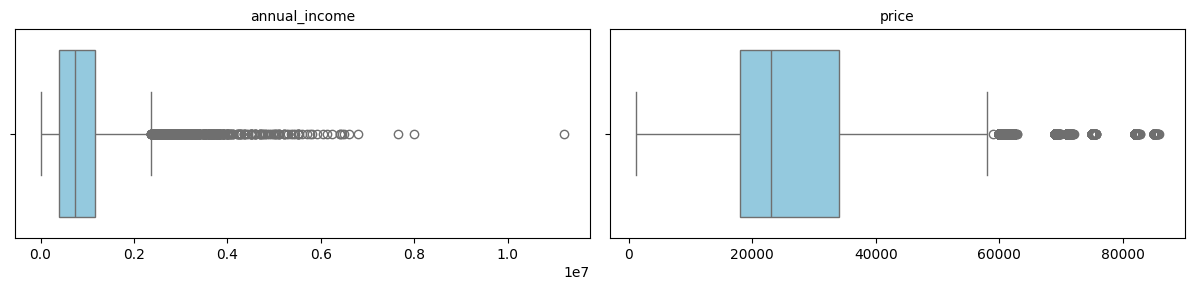

In [10]:
kolom_numerik = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_columns = len(kolom_numerik)
num_cols = 3
num_rows = (num_columns + num_cols - 1) // num_cols

plt.figure(figsize=(18, num_rows * 3))
for i, column in enumerate(kolom_numerik, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(x=df[column], orient='h', color='skyblue')
    plt.title(column, fontsize=10)
    plt.xlabel("")

plt.tight_layout()
plt.show()

Bersihkan outlier

In [11]:
def drop_outlier(df,coloumn):
    Q1 = df[coloumn].quantile(0.25)
    Q3 = df[coloumn].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    outliers = df[(df[coloumn] < (lower_bound)) | (df[coloumn] > (upper_bound))]
    df = df[~df.index.isin(outliers.index)]
    return df

df = drop_outlier(df, 'annual_income')
df = drop_outlier(df, 'price')

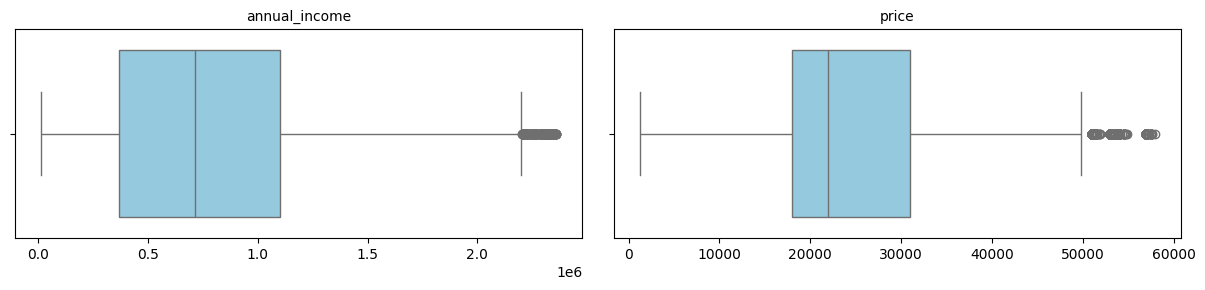

In [12]:
kolom_numerik = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_columns = len(kolom_numerik)
num_cols = 3
num_rows = (num_columns + num_cols - 1) // num_cols

plt.figure(figsize=(18, num_rows * 3))
for i, column in enumerate(kolom_numerik, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(x=df[column], orient='h', color='skyblue')
    plt.title(column, fontsize=10)
    plt.xlabel("")

plt.tight_layout()
plt.show()

# K-Means Clustering
*Mengidentifikasi dan memetakan minimal 3 segmen pelanggan yang berbeda berdasarkan perilaku belanja mereka (kombinasi pendapatan tahunan dan harga mobil yang dibeli).*

Memilih fitur untuk clustering

In [13]:
features_for_clustering = df[['annual_income', 'price']]

Standarisasi fitur

In [14]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_for_clustering)

Menentukan jumlah cluster optimal menggunakan Elbow Method


In [15]:
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

Plot Elbow Method


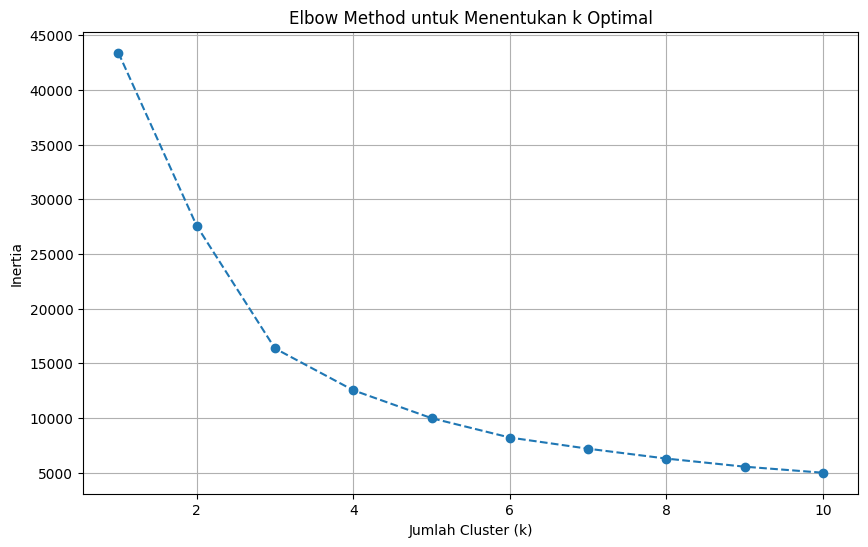

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method untuk Menentukan k Optimal')
plt.grid(True)
plt.show()

Melatih model K-Means dengan k = 3


In [17]:
optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Customer_Segment'] = kmeans.fit_predict(features_scaled)

Menganalisis hasil cluster dengan menampilkan rata-rata per segmen


In [18]:
print("Analisis Segmen Pelanggan (Rata-rata per segmen):")
df.groupby('Customer_Segment')[['annual_income', 'price']].mean()

Analisis Segmen Pelanggan (Rata-rata per segmen):


,annual_income,price
Customer_Segment,,
0,1.385639e+06,21679.027432
1,6.878902e+05,41955.402277
2,4.025225e+05,20114.742380


Visualisasi hasil clustering


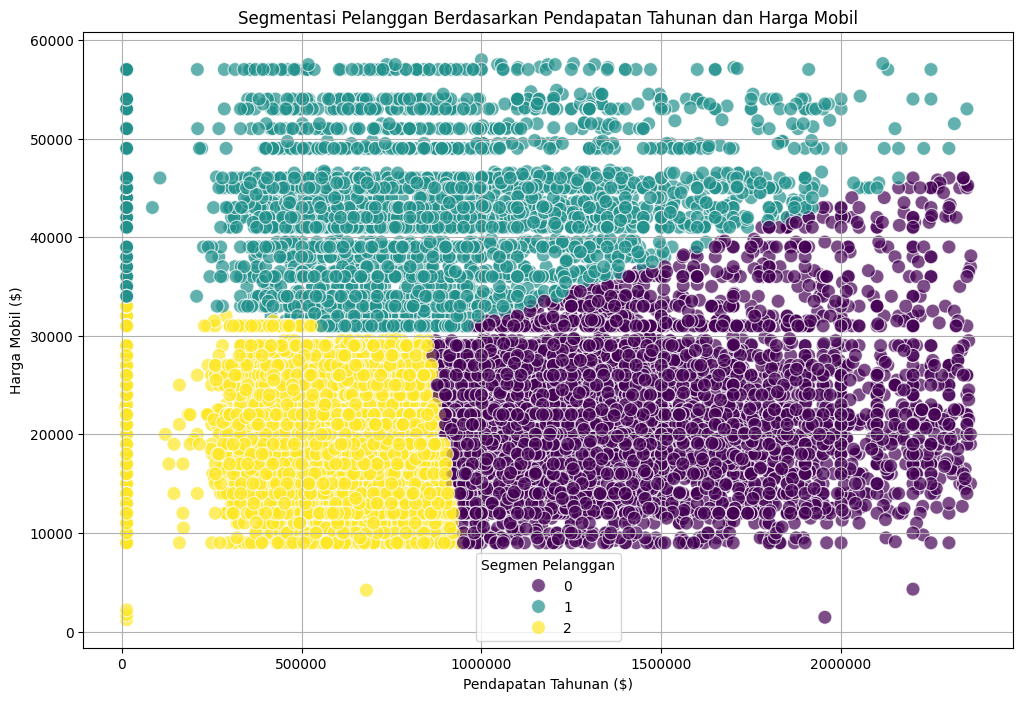

In [19]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='annual_income', y='price', hue='Customer_Segment', palette='viridis', s=100, alpha=0.7)
plt.title('Segmentasi Pelanggan Berdasarkan Pendapatan Tahunan dan Harga Mobil')
plt.xlabel('Pendapatan Tahunan ($)')
plt.ylabel('Harga Mobil ($)')
plt.legend(title='Segmen Pelanggan')
plt.grid(True)
plt.ticklabel_format(style='plain', axis='x')
plt.show()

In [20]:
df.head()

,Date,Customer Name,gender,annual_income,car_company,Model,engine_type,transmission,price,body_style,Customer_Segment
0,1/2/2022,Geraldine,Male,13500,Ford,Expedition,DoubleÂ Overhead Camshaft,Auto,26000,SUV,2
1,1/2/2022,Gia,Male,1480000,Dodge,Durango,DoubleÂ Overhead Camshaft,Auto,19000,SUV,0
2,1/2/2022,Gianna,Male,1035000,Cadillac,Eldorado,Overhead Camshaft,Manual,31500,Passenger,0
3,1/2/2022,Giselle,Male,13500,Toyota,Celica,Overhead Camshaft,Manual,14000,SUV,2
4,1/2/2022,Grace,Male,1465000,Acura,TL,DoubleÂ Overhead Camshaft,Auto,24500,Hatchback,0


Mendapatkan nilai centroid

In [21]:
centroids_scaled = kmeans.cluster_centers_
centroids_original_scale = scaler.inverse_transform(centroids_scaled)

In [22]:
df_centroids = pd.DataFrame(centroids_original_scale, columns=['avg_annual_income', 'avg_price'])
print("Karakteristik Rata-rata (Centroid) dari Setiap Cluster:")
df_centroids

Karakteristik Rata-rata (Centroid) dari Setiap Cluster:


,avg_annual_income,avg_price
0,1.384838e+06,21687.317950
1,6.873298e+05,41960.420845
2,4.020607e+05,20113.717106


In [23]:
pembeli_hemat_id = df_centroids['avg_price'].idxmin()
entusias_premium_id = df_centroids['avg_price'].idxmax()

Membuat dictionary mapping secara dinamis

In [24]:
dynamic_segment_map = {}
for i in range(len(df_centroids)):
    if i == pembeli_hemat_id:
        dynamic_segment_map[i] = 'Pembeli Hemat'
    elif i == entusias_premium_id:
        dynamic_segment_map[i] = 'Entusias Premium'
    else:
        # Anda bisa memberi nama yang lebih sesuai, misal: Kelas Menengah
        dynamic_segment_map[i] = 'Kelas Menengah'

print("\nHasil Mapping Label Dinamis:")
print(dynamic_segment_map)


Hasil Mapping Label Dinamis:
{0: 'Kelas Menengah', 1: 'Entusias Premium', 2: 'Pembeli Hemat'}


Menerapkan mapping yang benar ke dataframe

In [25]:
df['customer_segment_name'] = df['Customer_Segment'].map(dynamic_segment_map)

In [26]:
df.head()

,Date,Customer Name,gender,annual_income,car_company,Model,engine_type,transmission,price,body_style,Customer_Segment,customer_segment_name
0,1/2/2022,Geraldine,Male,13500,Ford,Expedition,DoubleÂ Overhead Camshaft,Auto,26000,SUV,2,Pembeli Hemat
1,1/2/2022,Gia,Male,1480000,Dodge,Durango,DoubleÂ Overhead Camshaft,Auto,19000,SUV,0,Kelas Menengah
2,1/2/2022,Gianna,Male,1035000,Cadillac,Eldorado,Overhead Camshaft,Manual,31500,Passenger,0,Kelas Menengah
3,1/2/2022,Giselle,Male,13500,Toyota,Celica,Overhead Camshaft,Manual,14000,SUV,2,Pembeli Hemat
4,1/2/2022,Grace,Male,1465000,Acura,TL,DoubleÂ Overhead Camshaft,Auto,24500,Hatchback,0,Kelas Menengah


# LightGBM (Light Gradient Boosting Machine) Classification
*Membangun model yang mampu memprediksi preferensi tipe bodi mobil pelanggan berdasarkan profil dan spesifikasi mobil yang diminati.*



Memilih fitur untuk klasifikasi

In [27]:
features_for_classification = ['annual_income', 'gender', 'car_company', 'transmission', 'engine_type', 'price']
target_for_classification = 'body_style'

In [28]:
X = df[features_for_classification]
y = df[target_for_classification]

Encoding fitur (X) dan target (y)

In [29]:
X_encoded = pd.get_dummies(X, columns=['gender', 'car_company', 'transmission', 'engine_type'], drop_first=True)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

Split data

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

Latih model LightGBM

In [31]:
model_lgbm = lgb.LGBMClassifier(random_state=42)
model_lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 537
[LightGBM] [Info] Number of data points in the train set: 15187, number of used features: 34
[LightGBM] [Info] Start training from score -2.060332
[LightGBM] [Info] Start training from score -1.362031
[LightGBM] [Info] Start training from score -1.817437
[LightGBM] [Info] Start training from score -1.304101
[LightGBM] [Info] Start training from score -1.700510


LGBMClassifier(random_state=42)

Prediksi model

In [32]:
y_pred = model_lgbm.predict(X_test)

Cek accuracy score

In [33]:
accuracy_pivot = accuracy_score(y_test, y_pred)

print(f"Akurasi Model LightGBM: {accuracy_pivot}")

Akurasi Model LightGBM: 0.7984639016897082


Cek classification report

In [34]:
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

     Hardtop       0.58      0.68      0.63       830
   Hatchback       0.85      0.75      0.80      1668
   Passenger       0.90      0.88      0.89      1057
         SUV       0.79      0.78      0.79      1767
       Sedan       0.84      0.90      0.87      1188

    accuracy                           0.80      6510
   macro avg       0.79      0.80      0.79      6510
weighted avg       0.80      0.80      0.80      6510



Cek confusion matrix

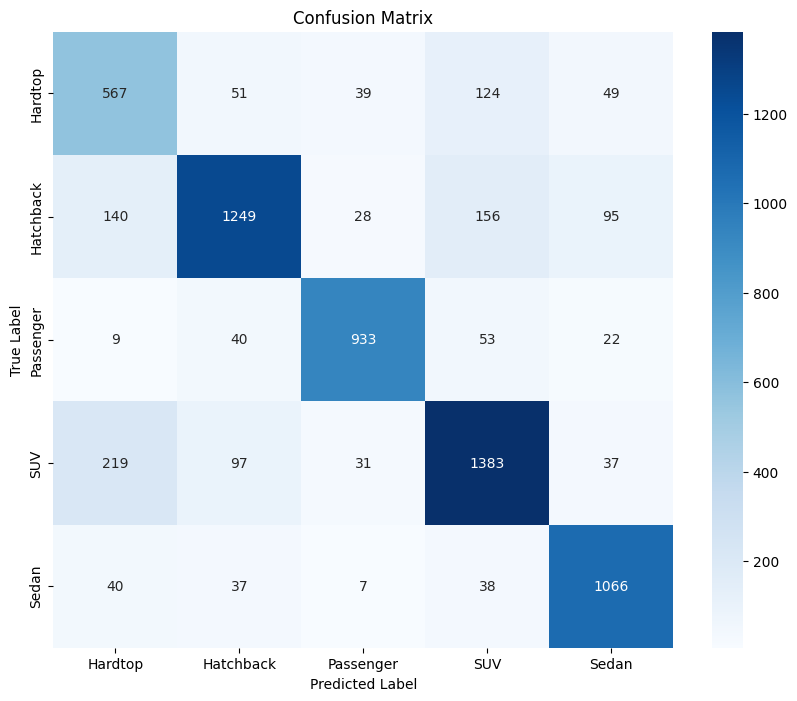

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Mengubah kembali prediksi dari angka ke nama label asli

In [36]:
predictions_text = le.inverse_transform(y_pred)

Menambahkan kolom hasil prediksi ke dataframe

In [37]:
df_test = df.loc[X_test.index].copy()
df_test['predicted_body_style'] = predictions_text

df_test.head()

,Date,Customer Name,gender,annual_income,car_company,Model,engine_type,transmission,price,body_style,Customer_Segment,customer_segment_name,predicted_body_style
23475,12/24/2023,Cedric,Male,850000,Mercedes-B,CL500,Overhead Camshaft,Manual,29000,SUV,2,Pembeli Hemat,SUV
17426,9/2/2023,Tristan,Male,1150000,Volvo,S40,DoubleÂ Overhead Camshaft,Auto,42001,Sedan,1,Entusias Premium,Sedan
7240,10/26/2022,Eliana,Male,770000,Mercedes-B,SLK,DoubleÂ Overhead Camshaft,Auto,19000,Passenger,2,Pembeli Hemat,Passenger
4311,8/2/2022,Emma,Male,810000,Mercury,Cougar,DoubleÂ Overhead Camshaft,Auto,33000,Hatchback,1,Entusias Premium,Hatchback
13218,4/30/2023,Hannah,Male,1400000,Mercedes-B,CLK Coupe,DoubleÂ Overhead Camshaft,Auto,22001,Sedan,0,Kelas Menengah,Sedan
